# Model of Wind Turbine
Convert kinectic energy of wind to mechanical energy of turbine

In [32]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as pl

In [17]:
# Define constant for wind turbine conversion
density = 1.225 #kg/m^3
blade_radius = 35 #m
v = 12 #m/s wind velocity
t_s_ratio = 8 # optimum tip to speed ratio
cp_optimal = 0.4 # when pittch angle is 0degree


In [20]:
# need to find the optimum of these variable
beta_optimal = None #degree pitch angle
wm = None

# model
pm_optimal = 0 # W
cp_optimal = 0 
tip_speed_rm = None
for w in np.arange(0.1,100,0.1):
    for beta in np.arange(0,180,1):
        tip_speed_r = blade_radius * w / v 
        gama = 1/(tip_speed_r+0.089)-0.035/(beta**3+1) # 1 over gama
        cp = 0.22*(116*gama-0.4*beta-5)*math.exp(-12.5*gama)
        pm = 0.5*density*math.pi*(blade_radius**2)*(v**3)*cp
        if pm > pm_optimal:
            wm = w
            tip_speed_rm = tip_speed_r
            pm_optimal = pm
            cp_optimal = cp
            beta_optimal = beta
torque = pm_optimal / wm

0 6.125 2.1 0.43794242258797267 1783827.3117736573


# Model of PMSG
Permanent Magnet Sychronous Generator

### Define the machine parameter

In [80]:
rs = 0.01 # Stator resistance in omega
ld = 0.0055 # d-axis inductance in H
lq = 0.00375 # q-axis inductance in H
p = 56 # number of poles
f = 50 # frequency in Hz
pf = 10 # permanent flux in Wb
tmech = 900 # moment of inertia in kgm2

In [22]:
ws = 2 * np.pi * f

### Space Vector Transformation

In [23]:
def space_vector(v3phase):
    vu = v3phase[0]  
    vv = v3phase[1]  
    vw = v3phase[2]  
    a = -0.5 + 0.866j  #e^{2pi/3} = cos(2pi/3) + jsin(2pi/3)
    vc = (2.0/3.0)*(vu + vv*a + vw*a**2) 
    vs_alpha = vc.real  
    vs_beta = vc.imag   
    return vs_alpha, vs_beta  #returns real and imaginary parr

In [54]:
def get_space_vector(angle):
    v30 = [230*np.cos(angle), 230*np.cos(angle - 2*np.pi/3.0), \
                    230*np.cos(angle - 4.0*np.pi/3.0)]
    vd, vq = space_vector(v30)
    return vd, vq

### Dynamic Equation for PWSG

In [78]:
def PMSG(X, t, vd, vq):
    x0 = X[0] # id
    x1 = X[1] # iq
    x2 = X[2]
    dx0dt = -rs*x0/ld + x2*lq*x1/ld + vd/ld
    dx1dt = -rs*x1/lq - x2*(ld*x0/lq + pf/lq) + vq/lq
    me = 1.5*p/2*(pf*x1 + (ld-lq)*x0*x1)
    dx2dt = (me-torque)/tmech
    return [dx0dt,dx1dt,dx2dt]

In [96]:
tstart = 0
tend = 0.5*wm*100
tinc = 0.01
ts = np.arange(tstart,tend,tinc)
sols = np.zeros((len(ts),3))
ids = np.zeros(len(ts))
iqs = np.zeros(len(ts))
mes = np.zeros(len(ts))
ws = np.zeros(len(ts))
mes = np.zeros(len(ts))

# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

x0 = [0, 0, 0]

for ii in range(len(ts)):
    angle = wm*ts[ii]-int(wm*ts[ii]/np.pi/2)*2*np.pi # get the angle at this moment
    vd, vq = get_space_vector(angle) # transform to dq axis
    solx = odeint(PMSG, x0, [0,tinc], args=(vd, vq), atol = abserr, rtol = relerr)
    sols[ii] = solx[-1]
    x0 = solx[-1]
    ids[ii] = sols[ii][0]
    iqs[ii] = sols[ii][1]
    ws[ii] = sols[ii][2]
    
for ii in range(len(ts)):    
    mes[ii] = 1.5*p/2*(pf*ids[ii] + (ld-lq)*ids[ii]*iqs[ii])


c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Plot the graph

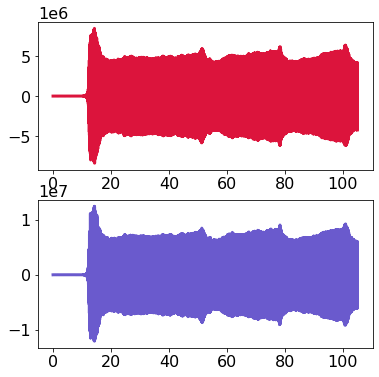

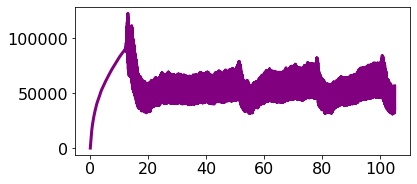

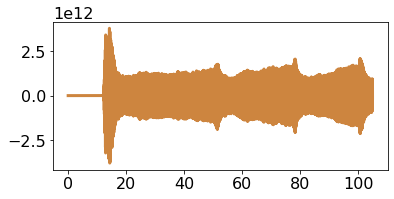

In [97]:
pl.figure(1,figsize=(6,6))
pl.rc('font',size = 16)
ax1 = pl.subplot(2,1,1)
ax1.plot(ts,ids,'crimson',lw=3)
# ax2 = ax1.twinx()
ax2 = pl.subplot(2,1,2)
ax2.plot(ts,iqs,'slateblue',lw=3)

pl.figure(2,figsize=(6,6))
ax3 = pl.subplot(2,1,2)
ax3.plot(ts,ws,'purple',lw=3)

pl.figure(3,figsize=(6,6))
ax3 = pl.subplot(2,1,2)
ax3.plot(ts,mes,'peru',lw=3)

pl.show()